In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import gensim
import re
import nltk

seed = 798589991

In [2]:
comp_data = pd.read_csv("data/competition_data.csv")

In [19]:
test = comp_data.groupby('product_id')['product_id'].transform('count')
test = pd.DataFrame({'pid_count': test, 'product_id': comp_data['product_id'], 'conversion': comp_data['conversion']})

test['product_conversion_sum'] = test.groupby('product_id')['conversion'].transform('sum')
test['conv_frecuency'] = test['product_conversion_sum'] / test['pid_count']

In [21]:
test['product_id'].isna().sum()

152362

In [23]:
test['conversion'].isna().sum()

19211

In [24]:
comp_data["ROW_ID"].notna().sum()

19211

In [25]:
kaggle_data = comp_data[comp_data["ROW_ID"].notna()] 
kaggle_data['product_id'].isna().sum()

14500

In [3]:
comp_data.columns

Index(['accepts_mercadopago', 'available_quantity',
       'avg_gmv_item_domain_30days', 'avg_gmv_item_sel', 'avg_gmv_seller_bday',
       'avg_qty_orders_item_domain_30days', 'avg_qty_orders_item_sel_30days',
       'avg_si_item_sel_30day', 'benefit', 'boosted', 'category_id',
       'conversion', 'date', 'deal_print_id', 'domain_id', 'etl_version',
       'free_shipping', 'fulfillment', 'full_name', 'health', 'is_pdp',
       'product_id', 'item_id', 'listing_type_id', 'logistic_type',
       'main_picture', 'offset', 'original_price', 'platform', 'price',
       'print_position', 'print_server_timestamp', 'qty_items_dom',
       'qty_items_sel', 'site_id', 'sold_quantity', 'tags', 'title',
       'total_asp_item_domain_30days', 'total_asp_item_sel_30days',
       'total_gmv_domain_bday', 'total_gmv_item_30days', 'total_items_domain',
       'total_items_seller', 'total_orders_domain_30days',
       'total_orders_item_30days', 'total_orders_sel_30days',
       'total_si_domain_30days

In [36]:
# title
title = comp_data[['title', 'conversion']]
title = title.reset_index()
title['title_words'] = title['title'].apply(lambda x: str(x).upper().split() if not pd.isna(x) else [])

words = ['NUEVO','CUOTAS','OFICIAL', 'ENVIO', 'ENVÍO']

for word in words:
    title[word] = title['title_words'].apply(lambda x: word in x)

In [37]:
print(f"Nuevo: {title['NUEVO'].sum()}")
print(f"Cuotas: {title['CUOTAS'].sum()}")
print(f"Oficial: {title['OFICIAL'].sum()}")
print(f"Envio: {title['ENVIO'].sum()}")
print(f"Envío: {title['ENVÍO'].sum()}")

Nuevo: 1638
Cuotas: 3571
Oficial: 7306
Envio: 2192
Envío: 742


In [43]:
print(title[title['OFICIAL']==True]['conversion'].sum() / title['OFICIAL'].sum())
print(title[title['NUEVO']==True]['conversion'].sum() / title['NUEVO'].sum())
print(title[title['CUOTAS']==True]['conversion'].sum() / title['CUOTAS'].sum())
print(title[title['ENVIO']==True]['conversion'].sum() / title['ENVIO'].sum())

0.09485354503148097
0.13003663003663005
0.13945673480817697
0.07116788321167883


In [51]:
warranty_types = comp_data['warranty']
warranty_types = warranty_types.reset_index()
warranty_types['warranty_words'] = warranty_types['warranty'].apply(lambda x: str(x).upper().split() if not pd.isna(x) else [])

words = ['SIN','GARANTÍA','GARANTIA']

for word in words:
    warranty_types[word] = warranty_types['warranty_words'].apply(lambda x: word in x)

warranty_types['Numbers'] = warranty_types['warranty'].str.extract(r'(\d+)')
warranty_types['has_warranty'] = ~(((warranty_types['SIN'] & warranty_types['GARANTÍA']) | (warranty_types['SIN'] & warranty_types['GARANTIA'])) & warranty_types['Numbers'].isna())

comp_data['warranty'] = warranty_types['has_warranty']

#### Para Garantía

In [4]:
# warranty_types = comp_data['warranty']
# warranty_types = warranty_types.reset_index()
# warranty_types['Warranty Type Words'] = warranty_types['warranty'].apply(lambda x: str(x).upper().split() if not pd.isna(x) else [])

In [5]:
# # Define the words you want to check for
# words = ['SIN','GARANTÍA','GARANTIA','VENDEDOR:','VENDEDORES','VENDEDOR','VENDEDOR,','FÁBRICA:','FABRICA','FÁBRICA','FÁBRICA.','FÁBRICA,','MESES','MESES.','DÍAS','DIAS','DÍAS,','DÍAS.','AÑOS','AÑOS.','ANO','AÑO','AÑO.']

# # Check if each word exists in each warranty type
# for word in words:
#     warranty_types[word] = warranty_types['Warranty Type Words'].apply(lambda x: word in x)

# warranty_types['Numbers'] = warranty_types['warranty'].str.extract(r'(\d+)')

# warranty_types['is_warranty_fábrica'] = warranty_types['FÁBRICA:'] | warranty_types['FÁBRICA'] | warranty_types['FABRICA'] | warranty_types['FÁBRICA.'] | warranty_types['FÁBRICA,']
# warranty_types['is_warranty_vendedor'] = warranty_types['VENDEDOR:'] | warranty_types['VENDEDOR'] | warranty_types['VENDEDORES'] | warranty_types['VENDEDOR,']
# warranty_types['time_dias'] = warranty_types['DÍAS'] | warranty_types['DIAS'] | warranty_types['DÍAS,'] | warranty_types['DÍAS.']  
# warranty_types['time_meses'] = warranty_types['MESES'] | warranty_types['MESES.'] 
# warranty_types['time_años'] = warranty_types['AÑOS'] | warranty_types['AÑOS.'] | warranty_types['AÑO'] | warranty_types['ANO'] | warranty_types['AÑO.']
# warranty_types['has_warranty'] = ~(((warranty_types['SIN'] & warranty_types['GARANTÍA']) | (warranty_types['SIN'] & warranty_types['GARANTIA'])) & warranty_types['Numbers'].isna())

# warranty_types.drop(columns=words, inplace=True)

In [6]:
# # Create the 'time' column based on conditions
# conditions = [
#     warranty_types['time_meses'] & warranty_types['time_dias'],  # 'meses' 
#     warranty_types['time_años'] & warranty_types['time_meses'],   # 'meses'
#     warranty_types['time_años'],  # 'años'
#     warranty_types['time_meses'],  # 'meses'
#     warranty_types['time_dias']  # 'días'
# ]

# choices = ['meses', 'meses', 'años', 'meses', 'días']

# warranty_types['time'] = np.select(conditions, choices, default=np.nan)
# warranty_types.drop(columns=['time_meses', 'time_dias', 'time_años'], inplace=True)

In [7]:
# # Create the 'type_warranty' column based on conditions
# conditions = [
#     warranty_types['is_warranty_fábrica'],  # 'fábrica' 
#     warranty_types['is_warranty_vendedor'],   # 'vendedor'
# ]

# choices = ['fábrica', 'vendedor']

# warranty_types['type_warranty'] = np.select(conditions, choices, default=np.nan)
# warranty_types.drop(columns=['is_warranty_fábrica', 'is_warranty_vendedor'], inplace=True)

In [8]:
# warranty_types['warranty_time'] = np.where(warranty_types['Numbers'].isna() | warranty_types['time'].isna(), np.nan,
#                                            'warranty_time_' + warranty_types['Numbers'].astype(str) + '_' + warranty_types['time'].astype(str))

# warranty_types.drop(columns=['Numbers', 'time'], inplace=True)

In [9]:
# warranty_types_encoded = pd.get_dummies(warranty_types['type_warranty'])
# new_column_names = ['type_warranty_fabrica', 'type_warranty_nan', 'type_warranty_vendedor']
# warranty_types_encoded.columns = new_column_names
# warranty_types = pd.concat([warranty_types, warranty_types_encoded], axis=1)
# warranty_types.drop(columns=['type_warranty', 'Warranty Type Words'], inplace=True)

In [10]:
# warranty_types['warranty_time'] = warranty_types['warranty_time'].fillna('warranty_time_nan')
# warranty_types_encoded = pd.get_dummies(warranty_types['warranty_time'])
# warranty_types = pd.concat([warranty_types, warranty_types_encoded], axis=1)
# warranty_types.drop(columns=['warranty_time', 'warranty'], inplace=True)

In [11]:
# comp_data = pd.concat([comp_data, warranty_types], axis=1)
# comp_data.drop(columns=['warranty'], inplace=True)

In [12]:
comp_data[['print_server_timestamp', 'date']]

,print_server_timestamp,date
0,2020-03-06T00:19:30.735-0400,2020-03-06
1,2020-04-01T21:20:11.738-0400,2020-04-01
2,2020-04-08T18:38:48.360-0400,2020-04-08
3,2020-04-25T22:01:19.829-0400,2020-04-25
4,2020-03-10T13:20:56.633-0400,2020-03-10
...,...,...
199967,2020-04-12T14:35:44.784-0400,2020-04-12
199968,2020-04-03T17:32:53.035-0400,2020-04-03
199969,2020-04-01T22:51:08.898-0400,2020-04-01
199970,2020-04-08T11:32:27.563-0400,2020-04-08


In [13]:
comp_data['platform'].str.split('/').str[2].value_counts()

android    124781
desktop     35892
mobile      25092
ios         14207
Name: platform, dtype: int64

In [14]:
comp_data['warranty'].str.split().str[0].str.upper().eq('SIN').value_counts()

False    176190
True      23782
Name: warranty, dtype: int64

In [15]:
# counts_ult = comp_data['full_name'].str.split(' -> ').str[-1].value_counts()
# counts_pri = comp_data['full_name'].str.split(' -> ').str[0].value_counts()
# tal vez dejar la más amplia como OHE y la otra hacer algo de word2vec?

In [16]:
# Dropeo las columnas.
comp_data.drop('benefit', inplace=True, axis=1)
# comp_data.drop('user_id', inplace=True, axis=1)
comp_data.drop('uid', inplace=True, axis=1)
comp_data.drop('main_picture', inplace=True, axis=1)
comp_data.drop('category_id', inplace=True, axis=1)
comp_data.drop('domain_id', inplace=True, axis=1)
comp_data.drop('deal_print_id', inplace=True, axis=1)
comp_data.drop('etl_version', inplace=True, axis=1)
# comp_data.drop('product_id', inplace=True, axis=1)
comp_data.drop('site_id', inplace=True, axis=1)
comp_data.drop('item_id', inplace=True, axis=1)
comp_data.drop('date', inplace=True, axis=1)
comp_data.drop('accepts_mercadopago', inplace=True, axis=1)

In [17]:
# Diferenciar desktop, ios, android o mobile(/web/mobile debe ser desde navegador y /mobile/ios desde app)
comp_data['platform'] = comp_data['platform'].str.split('/').str[2]

In [18]:
# Obtener primera y última categoría
comp_data['category_first'] = comp_data['full_name'].str.split(' -> ').str[0]
comp_data['category_last'] = comp_data['full_name'].str.split(' -> ').str[-1]

comp_data.drop('full_name', inplace=True, axis=1)

In [19]:
# Transformo garantía en una columna binaria (True, False, NaN)
comp_data['warranty'] = (
    ~comp_data['warranty'].str.split().str[0].str.upper().eq('SIN')
).where(comp_data['warranty'].notna()).astype(bool)

In [20]:
# Creo una columna con el descuento (en porcentaje).
discount = (((comp_data['original_price'] - comp_data['price']) / comp_data['original_price']) * 100).astype(int)
comp_data['discount_%'] = discount

comp_data.drop('original_price', inplace=True, axis=1)

In [21]:
# Consigo los tags posibles.
unique_tags = []
for list in comp_data['tags']:
    list_split = list[1:len(list)-1].split(', ')
    for item in list_split:
        if not (item in unique_tags):
            unique_tags.append(item)

# Separo los tags en columnas de booleanos.
for tag in unique_tags:
    comp_data[tag] = comp_data['tags'].apply(lambda x: tag in x)

comp_data.drop('tags', inplace=True, axis=1)

In [22]:
# Hacer algo inteligente con la date.
comp_data['date'] = pd.to_datetime(comp_data['print_server_timestamp'])
comp_data['month'] = comp_data['date'].dt.month
comp_data['day'] = comp_data['date'].dt.day
comp_data['day_of_week'] = comp_data['date'].dt.dayofweek
comp_data['hour'] = comp_data['date'].dt.hour
comp_data['minute'] = comp_data['date'].dt.minute
comp_data['second'] = comp_data['date'].dt.second

comp_data.drop('date', inplace=True, axis=1)
comp_data.drop('print_server_timestamp', inplace=True, axis=1)

In [23]:
# Test
# comp_data = comp_data.loc[:,~comp_data.columns.str.startswith('warranty')]

In [24]:
# Esto puede generar data leakage pero como al final entrenamos con todo lo pruebo y valido con Kaggle

user_counting = comp_data['user_id'].value_counts()

uid_ratio = comp_data[['user_id', 'conversion']]
pid_ratio = comp_data[['product_id', 'conversion']]

# Calculate conversion frequency
conversion_frequency = pid_ratio.groupby('product_id')['conversion'].mean().reset_index()

# Calculate count of each unique product_id
product_id_count = pid_ratio['product_id'].value_counts().reset_index()
product_id_count.columns = ['product_id', 'pid_count']

# Merge the two DataFrames
result = pd.merge(conversion_frequency, product_id_count, on='product_id')

# Rename the columns if needed
result.rename(columns={'conversion': 'conv_freq_pid'}, inplace=True)

comp_data = pd.merge(comp_data, result, on='product_id')

# Calculate conversion frequency
conversion_frequency_user = uid_ratio.groupby('user_id')['conversion'].mean().reset_index()

# Calculate count of each unique product_id
user_id_count = uid_ratio['user_id'].value_counts().reset_index()
user_id_count.columns = ['user_id', 'uid_count']

# Merge the two DataFrames
result_uid = pd.merge(conversion_frequency_user, user_id_count, on='user_id')

# Rename the columns if needed
result_uid.rename(columns={'conversion': 'conv_freq_uid'}, inplace=True)

comp_data = pd.merge(comp_data, result_uid, on='user_id')


### Word2Vec

In [44]:
def tokenizer(raw_text):
    """
    Tokeniza y preprocesa un texto.

    Args:
        raw_text (str): Texto sin procesar.

    Returns:
        list: Lista de oraciones, donde cada oración es una lista de palabras.
    """
    sentences = sent_tokenize(raw_text)
    sentences = [word_tokenize(e) for e in sentences]
    sentences = [[e2 for e2 in e1 if re.compile("[A-Za-z]").search(e2[0])] for e1 in sentences]
    sentences = [[e2.lower() for e2 in e1] for e1 in sentences]
    return(sentences)

def average_vectors(title_tokens, model, stopwords=None):
    """
    Calcula el vector promedio de un conjunto de tokens utilizando un modelo Word2Vec.

    Args:
        title_tokens (list): Lista de tokens.
        model (gensim.models.Word2Vec): Modelo Word2Vec.
        stopwords (set, optional): Conjunto de palabras stopwords. Defaults to None.

    Returns:
        numpy.ndarray: Vector promedio.
    """
    title_tokens = [e2 for e1 in title_tokens for e2 in e1]
    title_tokens = [e for e in title_tokens if e in model.wv]
    if stopwords is not None:
        title_tokens = [e for e in title_tokens if e not in stopwords]
    if len(title_tokens) == 0:
        output = np.zeros(model.wv.vector_size)
    else:
        output = np.array([model.wv.get_vector(e) for e in title_tokens]).mean(0)
    return output


In [45]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gaston\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaston\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Para title

In [46]:
comp_data['title_tokens'] = comp_data['title'].map(tokenizer)

STOP_WORDS_SP = set(stopwords.words('spanish'))

# Creación del modelo Word2Vec
w2v_title = gensim.models.Word2Vec(vector_size=100,
                                   window=3,
                                   min_count=5,
                                   negative=15,
                                   sample=0.01,
                                   workers=8,
                                   sg=1)

# Creación del vocabulario a partir del corpus
w2v_title.build_vocab([e2 for e1 in comp_data['title_tokens'].values for e2 in e1], 
                       progress_per=10000)

# Entrenamiento del modelo Word2Vec
w2v_title.train([e2 for e1 in comp_data['title_tokens'].values for e2 in e1],
                total_examples=w2v_title.corpus_count,
                epochs=30, report_delay=1)

title_embs = comp_data['title_tokens'].map(lambda x: average_vectors(x, w2v_title, STOP_WORDS_SP))
embedding_title_columns = pd.DataFrame(title_embs.tolist(), columns=[f'title_emb_{i}' for i in range(100)])

In [ ]:
from sklearn.cluster import KMeans

evol_variabilidad = []
for k in range(10, 50):
    kmeans = KMeans(n_clusters=k, max_iter=30, n_init=20)
    kmeans.fit(embedding_title_columns)
    evol_variabilidad.append({"k": k, "var": kmeans.inertia_})

evol_variabilidad = pd.DataFrame(evol_variabilidad)

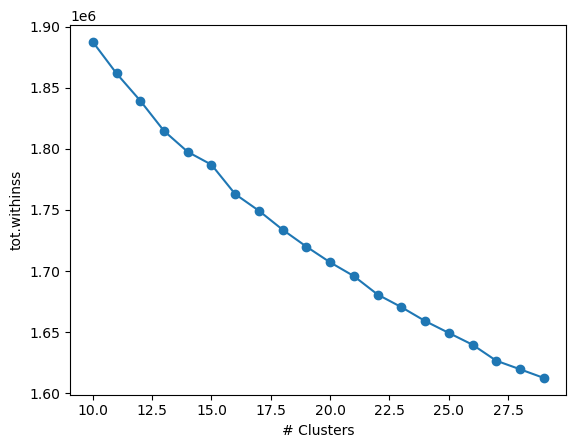

In [49]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(evol_variabilidad["k"], evol_variabilidad["var"], marker="o")
plt.xlabel("# Clusters")
plt.ylabel("tot.withinss")
plt.show()

In [ ]:
comp_data.drop('title_tokens', inplace=True, axis=1)
comp_data.drop('title', inplace=True, axis=1)
comp_data = pd.concat([comp_data, embedding_title_columns], axis=1)

In [ ]:
cols_to_encode = ['category_first', 'listing_type_id', 'logistic_type', 'platform', 'category_last']
comp_data_encoded = pd.get_dummies(comp_data[cols_to_encode])
comp_data = pd.concat([comp_data, comp_data_encoded], axis=1)
comp_data.drop(columns=cols_to_encode, inplace=True, axis=1)

In [ ]:
# Antes de empezar el entrenamiento del modelo, paso a int las columnas de booleano. Lo hago así para no tener problemas con los NaNs
comp_data.replace({False: 0, True: 1}, inplace=True)

In [ ]:
comp_data.to_csv("data/new_data.csv", index=False)

In [ ]:
# AUC-ROC validación: 0.89293 --> xgboost_model_w2v_2709
# AUC-ROC validación: 0.89365 --> xgboost_model_w2v100_war_2709